# Random Ensemble Orchestration - With get STATE


## RL test

Defining the Simulation enviroment

In [1]:
from config_manager import ConfigManager
import logging
import os
import numpy as np
from state_manager import StateManager 
from visualization_manager import VisualizationManager, DashApp

import gym
from gym import spaces


class SimulationEnv(gym.Env):

    def __init__(self):
        super(SimulationEnv, self).__init__()

        current_dir = os.getcwd()   
        print(current_dir)
        parent_dir = os.path.dirname(current_dir)
        CONFIG_PATH = os.path.join(current_dir, "sim_config.yaml")
        PROFILE_PATH = os.path.join(current_dir, "profile/model_profile/model_profile.yaml")
        print(PROFILE_PATH)

        self.state_manager = StateManager(current_dir)
        self.config_manager = ConfigManager(PROFILE_PATH, CONFIG_PATH)
        self.visualization_manager = VisualizationManager()
        self.dash_app = DashApp(self.visualization_manager)

        self.dash_app.run()

        # Define constants
        self.state_size = self.state_manager.state_lenght # Change this to be dynamic based on the enviroment
        # Observation space: Fixed size of 55
        self.observation_space = spaces.Box(
            low=0.0, high=10.0, shape=(self.state_size,), dtype=np.float32
        )

        # Action space (example: add/remove/replace a model)
        self.action_space = spaces.Discrete(3)

        self.weights = {
            "accuracy": 1.0,
            "confidence": 0.0,
            "latency": 0.0,
            "energy": 0.0,
            "explainability": 0.0
        }

    def reset(self):
        # Reset the environment to an initial state
        # Define Init Data:
        
        self.current_state = self.state_manager.get_state()  # Get initial state
        
        return self.state_manager.flatten_structured_state(self.current_state)

    def step(self, action):
        
        if action == 0:
            self.apply_action("keep_ensemble")
        elif action == 1:
            self.apply_action("add_model")
        elif action == 2:
            self.apply_action("replace_model")
      
        state = self.state_manager.get_state()
        print("STATE: ", state)

        # Simulate a step in the environment
        self.current_state = state
        reward = self._calculate_reward(self.current_state)
        self.visualization_manager.reward_list.append(reward)
        self.dash_app.update_graph()

        print("REWARD: ", reward)

        done = False  # Define termination condition if applicable
        
        return  self.state_manager.flatten_structured_state(self.current_state), reward, done, {}


    def _calculate_reward(self, state):
        model_states = state["model_states"]
        reward = 0.0
        
        metrics = model_states["ensemble"]
        
        reward += self.weights["accuracy"] * metrics["accuracy"]
        reward += self.weights["confidence"] * metrics["confidence"]

        return reward
    
    def apply_action(self, action):
    
        weights = self.weights
        manager = self.config_manager
        if action == "keep_ensemble":
            logging.info("Action: Keeping the ensemble")
        
        elif action == "add_model":
            manager.add_best_model(weights)
            logging.info("Action: Adding a model")
            # Logic for adding a new model (Placeholder)
        elif action == "replace_model":
            logging.info("Action: Replacing a model")
            manager.remove_worst_model(weights)
            manager.add_best_model(weights)
            # Logic for replacing a model (Placeholder)
        elif action == "remove_model":
            manager.remove_worst_model(weights)

        elif action == "add_random_model":
            manager.add_random_model()
        elif action == "remove_random_model":
            manager.remove_random_model()
        elif action == "replace_random_model":
            manager.remove_random_model()
            manager.add_random_model()


        else:
            logging.warning("Unknown action")

Running the simulation

In [2]:
from stable_baselines3 import PPO

#setup_config()

# Create the environment
env = SimulationEnv()

# Train the agent
model = PPO("MlpPolicy", env, verbose=1, n_steps=1028)
model.learn(total_timesteps=1)

# Save the trained model
model.save("simulation_policy")


c:\Documents\Aalto Semester 2\ResearchCloud\RL_simulation


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Documents\\Aalto Semester 2\\ResearchCloud\\profile/model_profile/model_profile.yaml'

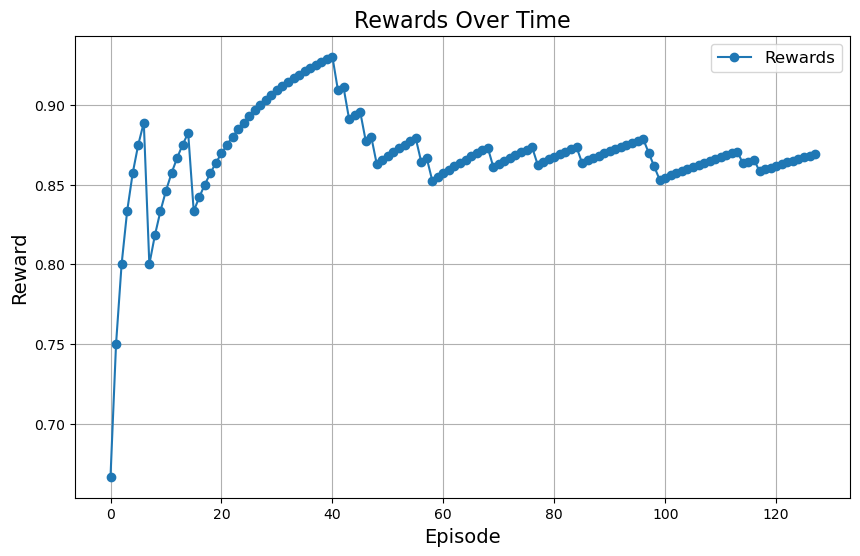

In [3]:

import matplotlib.pyplot as plt

# Assuming env.visualization_manager.reward_list is a list of rewards
def plot_rewards(reward_list):
    plt.figure(figsize=(10, 6))
    plt.plot(reward_list, label="Rewards", marker='o', linestyle='-')
    plt.title("Rewards Over Time", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()

# Example usage:
if hasattr(env, 'visualization_manager') and hasattr(env.visualization_manager, 'reward_list'):
    plot_rewards(env.visualization_manager.reward_list)
else:
    print("reward_list not found in env.visualization_manager.")